### GPT_DNA2DNA_model_1a_single

In [1]:
# S2S_GPT with Accuracy Plot

import re
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# ----------------------------------------------------
# 1. Parsing the FASTA and Chunking DNA
# ----------------------------------------------------

def parse_fasta_and_chunk(fasta_path, chunk_size=1024, max_samples=25000):
    """
    Read a FASTA file (assuming one contiguous chromosome sequence)
    and split it into chunks of `chunk_size` bp.
    Return a list of up to `max_samples` DNA chunks, randomly sampled if needed.
    """
    sequence_parts = []
    with open(fasta_path, 'r') as f:
        for line in f:
            if line.startswith(">"):
                continue
            sequence_parts.append(line.strip())
    full_sequence = "".join(sequence_parts)

    # Create chunks of size `chunk_size`
    chunks = [full_sequence[i : i+chunk_size] for i in range(0, len(full_sequence), chunk_size)]
    # Keep only chunks of the exact size
    chunks = [c for c in chunks if len(c) == chunk_size]

    # If more chunks exist than max_samples, randomly sample them
    if len(chunks) > max_samples:
        random.shuffle(chunks)
        chunks = chunks[:max_samples]

    return chunks

In [3]:
# ----------------------------------------------------
# 2. Building a DataFrame for Model Input
# ----------------------------------------------------

def build_dna_dataframe(dna_chunks):
    """
    Build a pandas DataFrame from the list of DNA chunks.
    Each row contains one DNA sequence of chunk_size base pairs.
    """
    df = pd.DataFrame(dna_chunks, columns=["dna_sequence"])
    return df

In [4]:
# ----------------------------------------------------
# 3. Tokenization
# ----------------------------------------------------

dna_pattern = re.compile(r"[ATGCN]")

def tokenize_dna(dna_str):
    """
    Tokenize the DNA string by single nucleotides (A, T, G, C, N).
    """
    dna_str = dna_str.upper()
    tokens = dna_pattern.findall(dna_str)
    return tokens

def build_vocab(tokenized_dna_list):
    """
    Build a vocabulary from the list of tokenized DNA sequences.
    Returns char_to_index and index_to_char dicts.
    """
    tokens = set()
    for tokens_list in tokenized_dna_list:
        tokens.update(tokens_list)
    tokens = sorted(tokens)
    
    char_to_index = {token: i + 1 for i, token in enumerate(tokens)}  # 1-based
    index_to_char = {i + 1: token for i, token in enumerate(tokens)}

    # Reserve index 0 for <pad>
    char_to_index['<pad>'] = 0
    index_to_char[0] = '<pad>'

    return char_to_index, index_to_char

def encode_dna(seq, char_to_index):
    """
    Encode a DNA string into indices using char_to_index; unknown chars -> 0 (pad).
    """
    tokens = tokenize_dna(seq)
    return [char_to_index.get(t, 0) for t in tokens]

def decode_dna(indices, index_to_char):
    """
    Decode list of indices into a DNA string (ignoring <pad>).
    """
    return ''.join(index_to_char.get(idx, '') for idx in indices if idx > 0)


In [5]:
# ----------------------------------------------------
# 4. PyTorch Dataset / DataLoader
# ----------------------------------------------------

class DNADataset(Dataset):
    def __init__(self, df, char_to_index, max_length=None):
        """
        Minimal dataset for GPT-like training on DNA sequences.
        """
        self.df = df.reset_index(drop=True)
        self.char_to_index = char_to_index
        
        # Encode sequences
        self.encoded_seqs = [encode_dna(seq, self.char_to_index) for seq in self.df['dna_sequence']]
        
        # Determine max_length from the data if not given
        if max_length is None:
            max_length = max(len(x) for x in self.encoded_seqs)
        self.max_length = max_length

        # Pad them
        self.encoded_seqs_padded = []
        for seq in self.encoded_seqs:
            padded_seq = seq + [0] * (self.max_length - len(seq))
            self.encoded_seqs_padded.append(padded_seq)
        self.encoded_seqs_padded = torch.tensor(self.encoded_seqs_padded, dtype=torch.long)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        seq = self.encoded_seqs_padded[idx]
        # GPT-like next token prediction:
        input_seq = seq[:-1]
        target_seq = seq[1:]
        return input_seq, target_seq

In [6]:
# ----------------------------------------------------
# 5. Positional Encoding
# ----------------------------------------------------

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1024):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # shape (1, max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].to(x.device)
        return x

In [8]:
# ----------------------------------------------------
# 6. GPT-like Model for DNA (No Value)
# ----------------------------------------------------

class DNAGPT_NoValue(nn.Module):
    def __init__(self, vocab_size, embedding_dim, nhead, num_layers, max_length=1024, dropout_rate=0.1):
        super(DNAGPT_NoValue, self).__init__()
        self.embedding_dim = embedding_dim
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len=max_length)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            batch_first=True,
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc_out = nn.Linear(embedding_dim, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask.to(next(self.parameters()).device)

    def forward(self, src):
        embeddings = self.token_embedding(src) * math.sqrt(self.embedding_dim)
        embeddings = self.pos_encoder(embeddings)
        src_mask = self.generate_square_subsequent_mask(src.size(1))
        output = self.transformer_encoder(embeddings, mask=src_mask)
        output = self.dropout(output)
        logits = self.fc_out(output)
        return logits

In [9]:
# ----------------------------------------------------
# 7. Early Stopping
# ----------------------------------------------------

class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint_100.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.loss_min = val_loss


In [10]:
# ----------------------------------------------------
# 8. Accuracy Computation
# ----------------------------------------------------

def compute_accuracy(logits, targets, pad_idx=0):
    """
    Compute token-level accuracy, ignoring <pad> tokens in 'targets'.
    logits: (batch_size, seq_len, vocab_size)
    targets: (batch_size, seq_len)
    pad_idx: index of <pad>
    """
    with torch.no_grad():
        # Get predictions
        preds = logits.argmax(dim=-1)  # (batch_size, seq_len)
        # Flatten
        preds = preds.view(-1)
        targets = targets.view(-1)
        # Mask out <pad> tokens
        valid_mask = (targets != pad_idx)
        correct = (preds[valid_mask] == targets[valid_mask]).sum().item()
        total = valid_mask.sum().item()
        acc = (correct / total) if total > 0 else 0.0
    return acc


In [11]:
# ----------------------------------------------------
# 9. Training and Evaluation
# ----------------------------------------------------

def train_epoch(model, dataloader, optimizer, criterion, device, pad_idx=0):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    for input_seq, target_seq in dataloader:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        
        optimizer.zero_grad()
        logits = model(input_seq)  # (batch, seq_len, vocab_size)

        # Compute loss
        logits_flat = logits.view(-1, logits.size(-1))  # (batch*seq_len, vocab_size)
        target_flat = target_seq.view(-1)               # (batch*seq_len,)
        loss = criterion(logits_flat, target_flat)

        loss.backward()
        optimizer.step()

        # Accumulate loss
        batch_size = input_seq.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size

        # Compute accuracy for this batch
        batch_acc = compute_accuracy(logits, target_seq, pad_idx=pad_idx)
        total_acc += batch_acc * batch_size

    avg_loss = total_loss / total_samples
    ppl = np.exp(avg_loss)
    avg_acc = total_acc / total_samples
    return avg_loss, ppl, avg_acc


def evaluate(model, dataloader, criterion, device, pad_idx=0):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    with torch.no_grad():
        for input_seq, target_seq in dataloader:
            input_seq = input_seq.to(device)
            target_seq = target_seq.to(device)

            logits = model(input_seq)
            logits_flat = logits.view(-1, logits.size(-1))
            target_flat = target_seq.view(-1)

            loss = criterion(logits_flat, target_flat)

            # Accumulate
            batch_size = input_seq.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            # Accuracy
            batch_acc = compute_accuracy(logits, target_seq, pad_idx=pad_idx)
            total_acc += batch_acc * batch_size

    avg_loss = total_loss / total_samples
    ppl = np.exp(avg_loss)
    avg_acc = total_acc / total_samples
    return avg_loss, ppl, avg_acc

In [12]:
# ----------------------------------------------------
# 10. Generation Function
# ----------------------------------------------------

def generate_dna(model, start_sequence, char_to_index, index_to_char, max_length=256, device='cpu'):
    model.eval()
    encoded = [char_to_index.get(ch, 0) for ch in start_sequence]
    generated_seq = encoded.copy()
    
    for _ in range(max_length - len(encoded)):
        input_seq = torch.tensor([generated_seq], dtype=torch.long).to(device)
        logits = model(input_seq)
        next_token_logits = logits[0, -1, :]
        
        probs = torch.softmax(next_token_logits, dim=0)
        next_token = torch.multinomial(probs, num_samples=1).item()
        
        if next_token == char_to_index['<pad>']:
            break
        generated_seq.append(next_token)

    out_str = ''.join(index_to_char.get(idx, '') for idx in generated_seq)
    return out_str

Using mps device
Number of 256-bp chunks used: 25000
Preview of df_full_data:
                                        dna_sequence
0  TTCATTCAAGAAATATTTATTGAGCTAGAAAGGTCTAAGCATTCAG...
1  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2  NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3  GTCACAAAGAGGTGGCCATGTGAGATTGTAAACGCTGGTATTGAGG...
4  TCTTGGAGGCTTTGCTCATTTCTTTTTATTCTTTTTTCTCTAAACT...
Vocab size (including <pad>): 6
Training samples: 20000
Validation samples: 5000
Epoch 1: Train Loss=0.6156, Val Loss=0.6142, Train PPL=1.85, Val PPL=1.85, Train Acc=0.696, Val Acc=0.697
Validation loss decreased (inf --> 0.614175). Saving model ...
Epoch 2: Train Loss=0.6095, Val Loss=0.6133, Train PPL=1.84, Val PPL=1.85, Train Acc=0.701, Val Acc=0.699
Validation loss decreased (0.614175 --> 0.613291). Saving model ...
Epoch 3: Train Loss=0.6080, Val Loss=0.6117, Train PPL=1.84, Val PPL=1.84, Train Acc=0.702, Val Acc=0.700
Validation loss decreased (0.613291 --> 0.611720). Saving model ...
Epoch 

/var/folders/fw/cd1vxk4x57b1f2cpwmt7g49800k_fc/T/ipykernel_8122/471225307.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dna_checkpo

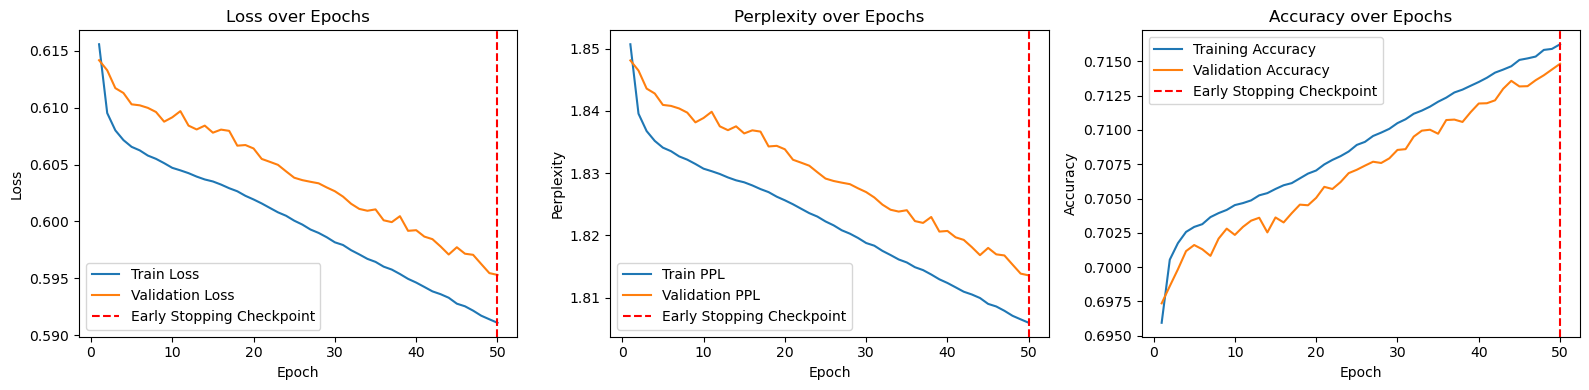

Model and vocab saved.
Generated DNA sequence:
ATGAATATGAGCCTTGCTGAAAACATCCCATGCCACAAAGGTAAATAGGTTATCACTCTGAGACTTCCGGCAGGCTGCCAGTTTCTCAAGCCAGGAATTGAGATAATATGGAAGGTTTGTATACCATAAATAATGTAGAGCCAAAGAAGATGTGCAAATGAATGCTGCTCTCAAAAAGAAATGAAGGAGGAGATTATATGATTGCCTATGTGGTGCTCAATTTGCTTCAAGAGCAAAAGAGTAAGCTATGTTAATG


In [14]:
# ----------------------------------------------------
# 11. Main Script
# ----------------------------------------------------

if __name__ == "__main__":
    # For reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    
    # If GPU is available, enable cudnn auto-tuner for speed
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True

    # Choose device
    device = (
        "cuda" if torch.cuda.is_available() else
        "mps" if torch.backends.mps.is_available() else
        "cpu"
    )
    print(f"Using {device} device")

    # A) Read and Randomly Sample Chunks from FASTA
    fasta_path = "Homo_sapiens.GRCh38.dna.chromosome.Y.fa"
    if not os.path.exists(fasta_path):
        raise FileNotFoundError(f"FASTA file '{fasta_path}' not found.")

    # We'll keep chunk_size=256 but limit to max_samples=25,000 for example
    dna_chunks = parse_fasta_and_chunk(fasta_path, chunk_size=256, max_samples=25000) # here <<<<<
    print("Number of 256-bp chunks used:", len(dna_chunks))

    # B) Build DataFrame
    df_full_data = build_dna_dataframe(dna_chunks)
    print("Preview of df_full_data:")
    print(df_full_data.head())

    # C) Tokenize to build vocabulary
    tokenized_dna_list = [tokenize_dna(seq) for seq in df_full_data["dna_sequence"]]
    char_to_index, index_to_char = build_vocab(tokenized_dna_list)
    vocab_size = len(char_to_index)
    print("Vocab size (including <pad>):", vocab_size)

    # D) Split data into train/valid
    df_train, df_valid = train_test_split(df_full_data, test_size=0.2, random_state=42)
    print("Training samples:", len(df_train))
    print("Validation samples:", len(df_valid))

    # E) Create datasets
    train_dataset = DNADataset(df_train, char_to_index)
    valid_dataset = DNADataset(df_valid, char_to_index, max_length=train_dataset.max_length)

    # F) Create Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        num_workers=2 if device == "cuda" else 0,
        pin_memory=True if device == "cuda" else False
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=2 if device == "cuda" else 0,
        pin_memory=True if device == "cuda" else False
    )

    # G) Initialize Model
    embedding_dim = 256
    nhead = 8
    num_layers = 4
    max_len = train_dataset.max_length  # typically 1024 for chunk size

    model = DNAGPT_NoValue(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        nhead=nhead,
        num_layers=num_layers,
        max_length=max_len,
        dropout_rate=0.1
    ).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss(ignore_index=char_to_index['<pad>'])

    # H) Early Stopping
    early_stopping = EarlyStopping(patience=3, verbose=True, path="dna_checkpoint.pt")

    # I) Training Loop
    num_epochs = 50
    train_losses, valid_losses = [], []
    train_ppls, valid_ppls = [], []
    train_accs, valid_accs = [], []

    PAD_IDX = char_to_index['<pad>']

    for epoch in range(1, num_epochs + 1):
        train_loss, train_ppl, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, pad_idx=PAD_IDX)
        valid_loss, valid_ppl, valid_acc = evaluate(model, valid_loader, criterion, device, pad_idx=PAD_IDX)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_ppls.append(train_ppl)
        valid_ppls.append(valid_ppl)
        train_accs.append(train_acc)
        valid_accs.append(valid_acc)

        print(f"Epoch {epoch}: "
              f"Train Loss={train_loss:.4f}, Val Loss={valid_loss:.4f}, "
              f"Train PPL={train_ppl:.2f}, Val PPL={valid_ppl:.2f}, "
              f"Train Acc={train_acc:.3f}, Val Acc={valid_acc:.3f}")

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best checkpoint
    model.load_state_dict(torch.load("dna_checkpoint.pt", map_location=device))
    print("Training complete. Best model loaded.")

    # J) Plot Loss, Perplexity, and Accuracy
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(16, 4))

    # 1) Loss subplot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    # Mark the early stopping epoch
    best_epoch = np.argmin(valid_losses) + 1
    plt.axvline(best_epoch, linestyle='--', color='r', label='Early Stopping Checkpoint')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # 2) Perplexity subplot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_ppls, label='Train PPL')
    plt.plot(epochs, valid_ppls, label='Validation PPL')
    plt.axvline(best_epoch, linestyle='--', color='r', label='Early Stopping Checkpoint')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Perplexity over Epochs')
    plt.legend()

    # 3) Accuracy subplot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_accs, label='Training Accuracy')
    plt.plot(epochs, valid_accs, label='Validation Accuracy')
    plt.axvline(best_epoch, linestyle='--', color='r', label='Early Stopping Checkpoint')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # K) Save Final Model and Vocab
    torch.save(model.state_dict(), 'dna_gpt_model.pth')
    with open('char_to_index.pkl', 'wb') as f:
        pickle.dump(char_to_index, f)
    with open('index_to_char.pkl', 'wb') as f:
        pickle.dump(index_to_char, f)
    print("Model and vocab saved.")

    # L) Example Generation
    test_prefix = "ATG"
    generated_sequence = generate_dna(
        model, test_prefix, char_to_index, index_to_char,
        max_length=256, device=device
    )
    print("Generated DNA sequence:")
    print(generated_sequence)